In [25]:
import pandas as pd
import numpy as np
import numpy.linalg as la
import scipy as sp 

import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.plotting import figure, show
from bokeh.models import Band, BoxAnnotation, ColumnDataSource, VBar, Span, Legend
from bokeh.io import output_notebook
from bokeh.palettes import Category10
output_notebook()

Loading BokehJS ...

# Transform matrix experiments on interpretability

JMA 12 AUg 2024

In [26]:

# File dependencies:
model_data = pd.read_parquet("../understanding_classifiers/model_data_top_1k_descriptors.parquet").reset_index()
model_data.head()

,name,target,intercept,beta_scaling_factor,beta_unit_vector,model_xval_auc,descriptor_id
0,Humans,D006801,2.691081,21.267867,"[0.017268219613741725, -0.01062624505004475, -...",0.911437,D006801
1,Female,D005260,0.572347,8.489115,"[-0.008675035508034886, 0.004081205739551541, ...",0.767340,D005260
2,Male,D008297,0.405352,8.966750,"[0.0035645856617138984, -0.03874317638897351, ...",0.759039,D008297
3,Animals,D000818,-1.375631,23.026027,"[0.025583062634139626, 0.03199666405386238, 0....",0.945004,D000818
4,Adult,D000328,-0.445872,9.237172,"[0.0039388731307771225, 0.0067770643253572795,...",0.763687,D000328


## The coefficient vectors create the transform matrix from the semantic embedding space to the the interpretable concept space

Each row is one coefficient vector, for one of the label-terms, e.g. MeSH terms, that occupy the semantic embedding space. 

Stacking coefficient vectors in a matrix forms a transform from the embedding space to the concept space, whose dimensions are labeled by the label-terms. z

In [27]:
# Extract the vector field and expand it to multiple rows. 
concept_transforms = np.vstack((model_data.beta_unit_vector).map(lambda x: np.asarray(x)))
transform_names= model_data.name
row_count, column_count = concept_transforms.shape
f'output dimension: {row_count}, input dimension: {column_count}'

'output dimension: 1000, input dimension: 768'

In [28]:
# Both the numpy version and the scipy version return the same results. 


u,s, vh = la.svd(concept_transforms)
u.shape, vh.shape


((1000, 1000), (768, 768))

In [29]:
u_df = pd.DataFrame(u).set_index(transform_names)
u_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
name,,,,,,,,,,,,,,,,,,,,,
Humans,-0.052650,-0.021678,0.053388,0.020011,0.037313,0.000577,0.012473,0.044893,-0.003251,0.000484,...,0.036559,0.003137,0.043687,-0.017777,-0.008842,0.017951,0.009542,-0.007797,0.017118,-0.024295
Female,-0.060258,-0.038184,0.030440,0.031408,0.003135,0.020829,0.001572,0.023175,-0.012600,0.025587,...,0.021385,-0.002036,0.004251,0.008469,0.067474,0.011397,0.026423,-0.020068,0.011627,-0.011855
Male,-0.039802,-0.043061,-0.001899,0.028714,-0.016116,0.004374,-0.005720,0.061326,-0.051550,0.024847,...,0.004003,0.014321,-0.037532,-0.014755,-0.002207,0.014100,-0.017842,0.019419,-0.012036,0.029792
Animals,0.066046,0.026274,-0.034563,-0.030598,-0.008184,-0.002377,-0.017518,-0.057648,-0.000521,0.021073,...,-0.028564,-0.058716,0.003505,-0.011700,-0.004497,0.018678,-0.016696,-0.000510,-0.003534,-0.012169
Adult,-0.058607,-0.020626,0.036488,0.015864,-0.009581,-0.003604,-0.001819,0.012720,0.005415,-0.007565,...,-0.043056,-0.024903,0.009749,0.044805,-0.008786,-0.029501,-0.030155,0.036353,0.051016,-0.044440


Text(0.5, 1.0, 'singular values magnitudes versus rank.')

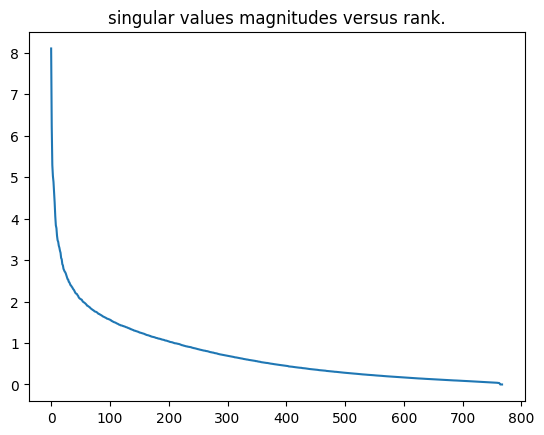

In [30]:
plt.plot(s)
plt.title('singular values magnitudes versus rank.')


### All rows and columns are unit length and rows and columns are orthogonal for both matricies

Text(0.5, 1.0, 'concept vector correlation heatmap')

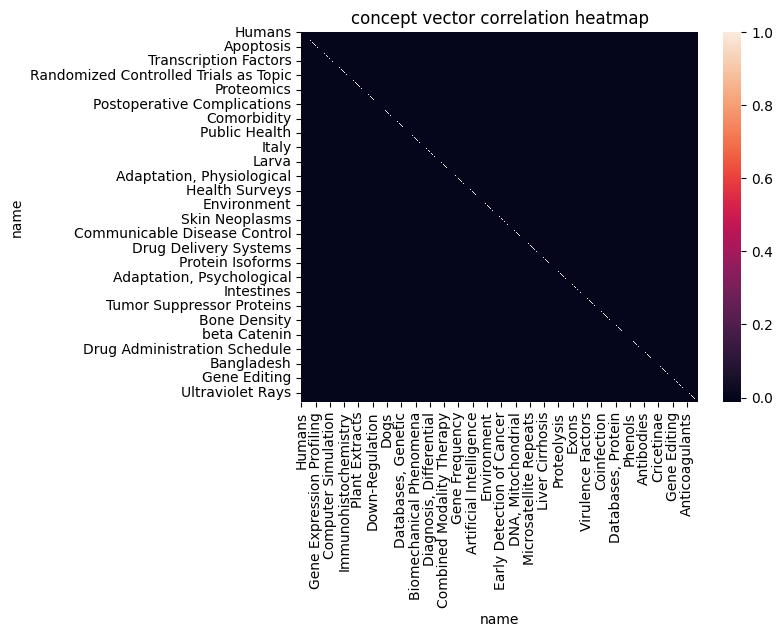

In [31]:
sns.heatmap(u_df.T.corr())
plt.title('concept vector correlation heatmap')

Text(0.5, 1.0, 'concept vector correlation transpose heatmap')

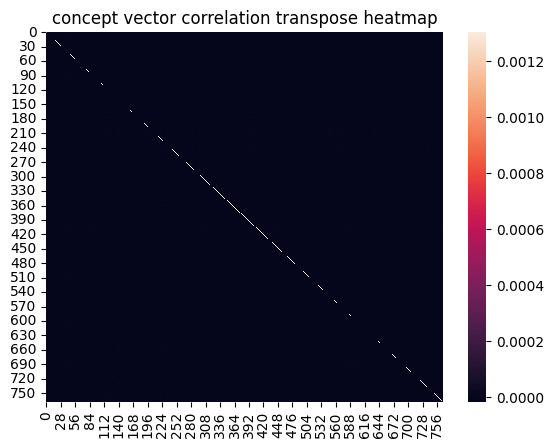

In [32]:
sns.heatmap(np.cov(vh.T))
plt.title('concept vector correlation transpose heatmap')

In [33]:
# Check u for unit lengths along both axes.
np.any(np.apply_along_axis(la.norm, 0, u) - 1.0 < 1e4), np.any(np.apply_along_axis(la.norm, 1, u) - 1.0 < 1e4)


(np.True_, np.True_)

In [34]:
# Check v for unit lengths along both axes. 
np.any(np.apply_along_axis(la.norm, 0, vh) - 1.0 < 1e4), np.any(np.apply_along_axis(la.norm, 1, vh.T) - 1.0 < 1e4)

(np.True_, np.True_)

### To use the SVD we constrain the rank of the singular values by just taking the upper left corner of s. 

In [35]:
# Reconstruct the transform from its SVD components
# Re
s_reconstruction = np.zeros([row_count, column_count])
s_reconstruction[:column_count, :column_count] = np.diag(s)
sub_concept_transforms = u @ s_reconstruction @ vh

In [36]:
# Does the svd reconstruct the original matrix? 
# np.allclose := two arrays are element-wise equal within a tolerance
np.allclose(concept_transforms, sub_concept_transforms)


True

In [249]:
# Create a limited rank approximation to the transform matrix matrix
def forward_svd_full(u, s, vh, sub_rank=column_count):
    ''
    s_reconstruction = np.zeros([sub_rank, sub_rank])
    s_reconstruction[:sub_rank, :sub_rank] = np.diag(s[:sub_rank])
    sub_concept_transforms = u[:row_count, :sub_rank] @ s_reconstruction @ vh[:sub_rank,:column_count]
    return sub_concept_transforms


In [ ]:
# Invert the transform and see if it recovers the original distance
low_rank = column_count

# A better version.   
# TODO compare this to svd(... full_matrices=False)
def forward_svd(u,s,vh, rank = low_rank):
    u_shape = u.shape      # u and v are square
    vh_shape = vh.shape
    s_reconstruction = np.zeros(u_shape)
    s_reconstruction[:low_rank, :low_rank] = np.diag(s[:low_rank])
    sub_concept = u @ s_reconstruction
    sub_concept_transform = sub_concept[:,:vh_shape[0]] @ vh
    return sub_concept_transform

def inverse_svd(u,s,v, rank = low_rank):
    return v.T[:rank, :rank] @ np.diag(1/s[:rank])  @ (u.T[:rank,:])

svd_inverse = inverse_svd(u,s,vh)
svd_inverse.shape
# Check the inverse
# There are a couple zeros on the diagonal. 
# la.det(svd_inverse @ concept_transforms[:,:low_rank]) # , np.round(svd_inverse @ concept_transforms)
# TODO - Check the inverse is the I matrix. 
np.sort(np.diagonal(svd_inverse @ concept_transforms[:,:low_rank]))

In [251]:
# Compute the normalized distance to the reduced rank matrix. 
# How good is the low rank approximation? 
la.norm(concept_transforms - forward_svd_full(u,s, vh))/la.norm(concept_transforms)

np.float64(4.016451491407243e-15)

In [248]:
# TODO Should give the same norm
la.norm(concept_transforms - forward_svd(u,s,vh, rank = low_rank)) /la.norm(concept_transforms)

np.float64(0.0024772657629324305)

In [39]:
# Create a hold out set from the 1000 - 768 terms. 
transfer_sample_indexes = np.sort(np.random.choice(range(row_count), column_count, replace=False))
hold_out_indexes = set(range(1000)).difference(set(transfer_sample_indexes))   # We loose the association with concept names sigh. 
# Check that the two sets are  mutually exclusive & exhaustive
len(transfer_sample_indexes) + len(hold_out_indexes), hold_out_indexes.intersection(set(transfer_sample_indexes))

(1000, set())

### Distances are not preserved from embedding to concept space by the transform

Make pair-wise comparisons between vectors in the hold out set and compare distances
before transform and after transform.

Look at the names of the hold out vectors, to see if distances between concept vectors
are more meaningful than among embedding vectors. 


In [40]:
# for pairs of held-out vectors, compute their cosine distances in embedding and concept spaces

# normalized cosine distance'
def cos_d(v1, v2):
    return sp.spatial.distance.cosine(v1, v2) - 1

transform = concept_transforms[transfer_sample_indexes,:]
hold_out_vectors = concept_transforms[list(hold_out_indexes),:]
hold_out_vectors_df = pd.DataFrame(hold_out_vectors).set_index(transform_names[list(hold_out_indexes)])

# hold_out_names = transform_names[list(hold_out_indexes)]  # set ordering is not preserved. 
    

def before_after_distance(v1, v2, transform_matrix):
    'compare how the transform changes the cosine distance'
    before  = cos_d(v1, v2)
    after = cos_d(transform_matrix @ v1, transform_matrix @ v2)
    return before, after




Text(0.5, 1.0, 'Transformed distances, Blue-full transform, Red-Low rank transform')

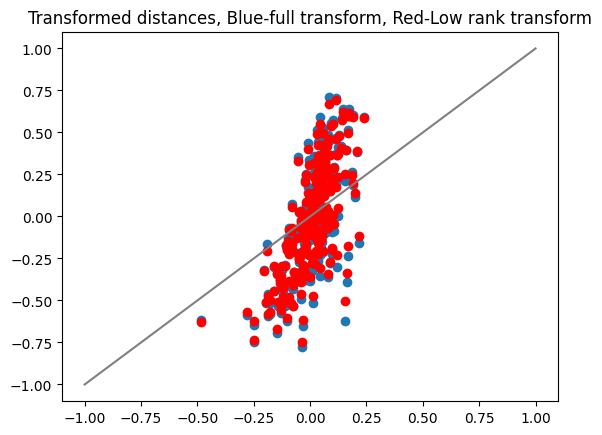

In [41]:
ba_distances = np.zeros([(len(hold_out_indexes)-1), 2])
for k in range(len(hold_out_indexes)-1):
    ba_distances[k, 0], ba_distances[k, 1] = before_after_distance(hold_out_vectors[k], hold_out_vectors[k+1], transform)
    #print(f'before: {b:.3}, after: {a:.3}')

ba_low_dim_distances = np.zeros([(len(hold_out_indexes)-1), 2])
for k in range(len(hold_out_indexes)-1):
    ba_low_dim_distances[k, 0], ba_low_dim_distances[k, 1] = before_after_distance(hold_out_vectors[k], hold_out_vectors[k+1], sub_concept_transforms)

plt.plot(ba_distances[:,0], ba_distances[:,1], 'o')

plt.plot(ba_low_dim_distances[:,0], ba_low_dim_distances[:,1], 'ro')
plt.plot([-1, 1], [-1, 1], color= 'grey')
plt.title('Transformed distances, Blue-full transform, Red-Low rank transform')

# TODO Add vector pair names to mouse-overs for each point

In [110]:
rank = 763
x = vh.T[:rank, :rank] @ np.diag(1/s[:rank])
la.det(x)

np.float64(-4.2496285351417464e+215)

In [254]:
# Invert the transform and see if it recovers the original distance
low_rank = 759

# A better version.   
# TODO compare this to svd(... full_matrices=False)
def forward_svd(u,s,vh, rank = low_rank):
    u_shape = u.shape      # u and v are square
    vh_shape = vh.shape
    s_reconstruction = np.zeros(u_shape)
    s_reconstruction[:low_rank, :low_rank] = np.diag(s[:low_rank])
    sub_concept = u @ s_reconstruction
    sub_concept_transform = sub_concept[:,:vh_shape[0]] @ vh
    return sub_concept_transform

def inverse_svd(u,s,v, rank = low_rank):
    return v.T[:rank, :rank] @ np.diag(1/s[:rank])  @ (u.T[:rank,:])

svd_inverse = inverse_svd(u,s,vh)
svd_inverse.shape
# Check the inverse
# There are a couple zeros on the diagonal. 
# la.det(svd_inverse @ concept_transforms[:,:low_rank]) # , np.round(svd_inverse @ concept_transforms)
# TODO - Check the inverse is the I matrix. 
np.sort(np.diagonal(svd_inverse @ concept_transforms[:,:low_rank]))[:16], np.argsort(np.diagonal(svd_inverse @ concept_transforms[:,:low_rank]))[:16]

(array([-5.99782263e-48,  2.76401197e-51,  1.20542710e-11,  1.19191182e-09,
         7.71134060e-01,  9.20580991e-01,  9.31783817e-01,  9.42135166e-01,
         9.52698076e-01,  9.54199997e-01,  9.71297878e-01,  9.75312364e-01,
         9.76463655e-01,  9.77215400e-01,  9.77374535e-01,  9.77431424e-01]),
 array([555, 756, 688,  34, 461, 643, 694, 382, 542, 609, 241,  50, 211,
         54, 732, 120]))

In [167]:
la.det(vh), la.det(np.diag(s[:768-80])), la.det(u)

(np.float64(1.0000000000001936),
 np.float64(2.6116294112699526e-175),
 np.float64(0.9999999999999063))

Text(0.5, 1.0, 'log determinant of singular values product (looking for epsilon entries)')

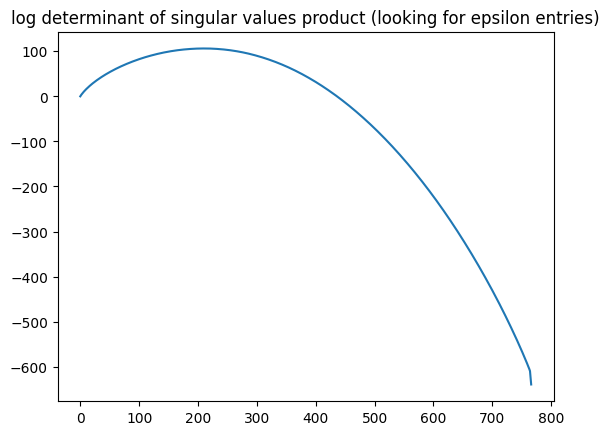

In [218]:
s_determinant = np.zeros((len(s)-1))
for k in range(len(s)-1):
    s_determinant[k] = np.log(np.prod(s[:k]))
plt.plot(s_determinant)
plt.title('log determinant of singular values product (looking for epsilon entries)')
                           


In [88]:
# THe last n singular values are near zero, and create a problem
id_s = np.argsort(s).astype('int')
list(zip(id_s.tolist(), np.sort(s).tolist()))[:10]

[(767, 4.7267043946142e-16),
 (766, 3.598817143361493e-15),
 (765, 9.925375548760399e-08),
 (764, 1.2212924236514005e-06),
 (763, 0.02083106034862287),
 (762, 0.03614085549707396),
 (761, 0.03679736186989901),
 (760, 0.03718290446656926),
 (759, 0.04074477785229813),
 (758, 0.04110609115800936)]

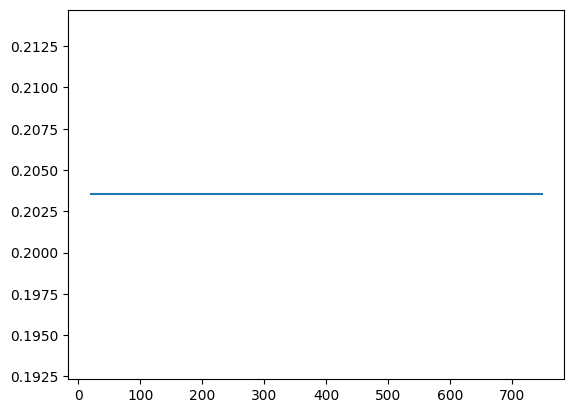

In [217]:
# How to test the inverse approximation. 
snips = 20
inverse_length = np.zeros(column_count)
x = range(snips , column_count - snips)
unit_vector = np.ones(column_count)/np.sqrt(column_count)
for k in x:
    inverse_length[k]  = la.norm(concept_transforms @ unit_vector)
# svd_inverse 
# inv_before = cos_d(svd_inverse @ concept_transforms @ v1, svd_inverse @ concept_transforms @ v2)
plt.plot(x, inverse_length[x])

### Conjecture - the concept vectors have lower entropy in the concept space. 

Create a hold-out set of coefficient vectors to test the transfer function.  Use them as test vectors in the embedding space.  

mean:  0.9485749764468459
mean:  0.943479424517386


Text(0.5, 1.0, 'Transformed vectors most often have lower entropy')

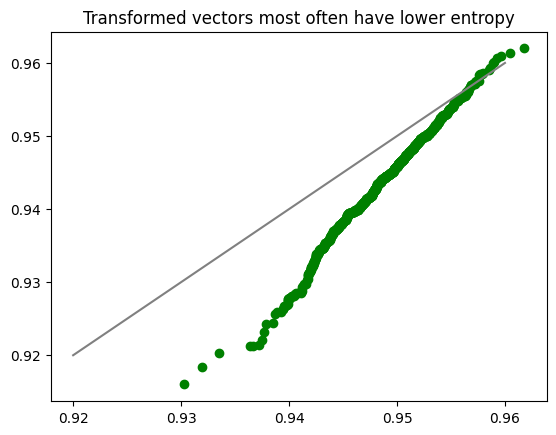

In [42]:
import scipy.stats as ss 

tranformed_hold_out_vectors = (transform @ hold_out_vectors.T).T

# ss.entropy(concept_transforms + 1E-1 * np.ones([row_count, column_count]))
x = np.abs(hold_out_vectors)
xe = ss.entropy(x)/ss.entropy(np.ones([len(x)]))
xe = np.sort(xe)
print('mean: ',np.mean(xe))

x1 = np.abs(tranformed_hold_out_vectors)
xe1 = ss.entropy(x1)/ss.entropy(np.ones([len(x1)]))
xe1 = np.sort(xe1)
print('mean: ',np.mean(xe1))

plt.plot(xe, xe1, 'og')
plt.plot([0.92, 0.96], [0.92,0.96], color='grey')
plt.title('Transformed vectors most often have lower entropy')



## Prominent concepts in individual singular value "spaces"

Each singular value corresponds to one component in the orthogonal space that is common to both the input and output space.  This is an attempt to associate semantic labels from the concept space (the "MeSH" terms) with individual components.  The challenge is that the mapping from the component space (where the singular values live) to the concept space is dense, so each concept has some contributions to any given component.

The first component can be interpreted as "all encompassing", meaning it tries to capture as much as possible for the entire set of concepts. This "bland" component is colored by the bias of the entire set.  It is representative of the set. 

Subsequent components are orthogonal, and "peel off" more specific concepts.  We investigate them by listing the most positive and negative coefficients when transformed, using the u matrix to concept space. 



## Inverse of the transform, using the SVD decomposition.

The SVD decomposition of $X$ consists of the matrices

$ X = USV^T $

Where $U$ and $V^T$ are unitary orthogonal matrices and $S$ is diagonal with non-zero entries equal to the rank of $X$. Since each of these matrices is invertible, the sequence $X^{*} = V^T 1/S\ U^T$ to within the column space (?) of $X$. 

In code:

```
U, S, V = np.linalg.svd(A, full_matrices=False) # compute SVD of A
Sinv = np.diag(1/S) # take reciprocal of singular values
Aplus = V.T @ Sinv @ U.T # compute pseudoinverse of A
```
